In [13]:

################################## LIBRARIES ################################## 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn_extra.cluster import KMedoids
from bertopic import BERTopic
from ast import literal_eval
from pathlib import Path
from tqdm import tqdm
from umap import UMAP
import pandas as pd
import numpy as np
import regex as re
import DrainMethod
import contextlib
import pickle
import sys
import os

############################## AUXILIARY METHODS ############################## 

# Code for reading HuggingFace token
def get_huggingface_token():
    f = open("huggingface_token.txt", "r")
    return (f.read())

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors_TFIDF.vec')
    path = Path(path_to_file)
    vectors_tfidf = []

    # if (path.is_file()):
    #     vectors_tfidf = pickle.load(open(path_to_file, 'rb'))
    # else:
    #     Using TFIDF Vectorizer 
    #     print("Starting encode")
    #     tr_idf_model  = TfidfVectorizer()
    #     vectors_tfidf = tr_idf_model.fit_transform(raw_content)
    #     pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))
    
    # Using TFIDF Vectorizer 
    tr_idf_model  = TfidfVectorizer()
    vectors_tfidf = tr_idf_model.fit_transform(raw_content)
    pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))

    return vectors_tfidf

def creates_lists(clusterer):

    ## General Parameters
    cluster_idxs = []
    cluster_lines = []
    output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
    output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

    ## Code

    # Reads parameters list
    full_df = pd.read_csv(output_csv)
    elem_df = full_df["EventTemplate"]

    # Creates blank lists
    for elem in range (clusterer.labels_.max()+1):
        cluster_idxs.append([])
        cluster_lines.append([])

    # Populate the lists with cluster elements
    for idx, elem in np.ndenumerate(clusterer.labels_):
        if elem != -1:
            cluster_idxs[elem].append(idx[0])
            cluster_lines[elem].append(elem_df[idx[0]])
        
    return (cluster_idxs, cluster_lines)

## Gets number of different templates using Drain
def get_template_number():

    target_file = "results/" + dataset + "_lines.txt_templates.csv"
    csv = pd.read_csv(target_file)
    content = csv["EventTemplate"]
    return (len(content))


################################# MAIN METHODS ################################ 

# Code for reading HuggingFace token
def get_huggingface_token():
    f = open("huggingface_token.txt", "r")
    return (f.read())

# Parse logs using Drain
def parse_logs(st=0.5, depth=5):
    st = st # Drain similarity threshold
    depth = depth # Max depth of the parsing tree

    ## Code
    parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
    parser.parse(log_file)

    parsedresult=os.path.join(output_dir, log_file + '_structured.csv')   

# Creates embeddings for log file
def transform(logName):
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

# Creates distance matrix, using Euclidean distance
def create_distance_matrix(vector_df):
    # Using Euclidean Distance between the rows of the TFIDF Matrix
    tfidf_distance = pairwise_distances(vector_df, metric="euclidean", n_jobs=-1)
    #Normalizes Distance Matrix with Min-Max
    min_val = np.min(tfidf_distance)
    max_val = np.max(tfidf_distance)
    tfidf_distance = (tfidf_distance - min_val) / (max_val - min_val)
    return (tfidf_distance)

# Creates variable matrix, using Jaccard distance
def create_variable_matrix():
    ## General Parameters
    output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
    output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

    ## Code
    # Reads parameters list
    full_df = pd.read_csv(output_csv)
    var_df = full_df["ParameterList"]

    # Breaks the string into lists
    for i, line in var_df.items():
        var_df.at[i] = literal_eval(var_df.at[i])

    # Transforms variable list to variable sparse matrix
    mlb = MultiLabelBinarizer(sparse_output=True)
    var_df = mlb.fit_transform(var_df)
    var_distance = pairwise_distances(np.asarray(var_df.todense()), metric="jaccard", n_jobs=-1)
    return (var_distance)

def creates_closeness_matrix(tfidf_distance):
    # Creates Count Matrix using line numbers from log lines as the counter
    count_list = []
    n = len(tfidf_distance)
    count_distance = np.zeros(shape=(n, n), dtype=int)
    for i in range(n):
            count_list.append(i)

    # Using a Subtraction Distance using the line numbers as a Count Matrix
    count_array = np.array(count_list)
    for x in count_array:
        for y in count_array:
            count_distance[x,y] = abs(x-y)
    # Normalizes Distance Matrix with Min-Max
    min_val = np.min(count_distance)
    max_val = np.max(count_distance)
    count_distance = (count_distance - min_val) / (max_val - min_val)
    return (count_distance)

def saves_matrices(distance_mat, variable_mat, closeness_mat):
    np.save("tfidf_distance_" + logName + ".csv", distance_mat)
    np.save("var_distance_" + logName + ".csv", variable_mat)
    np.save("count_distance_" + logName + ".csv", closeness_mat)

def loads_matrices():
    tfidf_distance = np.load("tfidf_distance_" + logName + ".csv")
    count_distance = np.load("count_distance_" + logName + ".csv")
    var_distance = np.load("var_distance_" + logName + ".csv") 
    return (tfidf_distance, count_distance, var_distance)

def joins_matrices(tfidf_distance, var_distance, count_distance, alpha, beta, gamma):

    if alpha+beta+gamma > 1:
        raise Exception("Values have to sum 1!")

    # New matrices, corrected by the weights
    tfidf_distance_wtd = np.dot(alpha,tfidf_distance)
    var_distance_wtd = np.dot(beta, var_distance)
    count_distance_wtd = np.dot(gamma, count_distance)

    # Sums remaining matrices
    unified_matrix = np.asarray(tfidf_distance_wtd + var_distance_wtd + count_distance_wtd)
    return (unified_matrix)

# def cluster_hdbscan(unified_matrix, cluster_size, mn_samples, cluster_selection_epsilon, alpha, leaf_size):
#     ## Clusters with HDBSCAN
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size,min_samples=mn_samples,metric='precomputed',
#                                 cluster_selection_epsilon=cluster_selection_epsilon, alpha=alpha, leaf_size=leaf_size, 
#                                 allow_single_cluster=False,cluster_selection_method='eom',
#                                 gen_min_span_tree=True)

#     clusterer.fit(unified_matrix)

#     ## Checks number of outliers
#     cont = np.count_nonzero(clusterer.labels_ == -1)
#     return (clusterer)

def cluster_kmedoids(unified_matrix, cluster_num):
    ## Clusters with cluster_kmedoids

    clusterer = KMedoids(n_clusters=cluster_num, method='pam', init='random')
    clusterer.fit(unified_matrix)

    ## Checks number of outliers
    cont = np.count_nonzero(clusterer.labels_ == -1)
    return (clusterer)

# def cluster_hdbscan_raw_data(data, cluster_size, mn_samples, cluster_selection_epsilon, alpha, leaf_size):
#     ## Clusters with HDBSCAN
#     clusterer = hdbscan.HDBSCAN(min_cluster_size=cluster_size,min_samples=mn_samples,metric='euclidean',
#                                 cluster_selection_epsilon=cluster_selection_epsilon, alpha=alpha, leaf_size=leaf_size, 
#                                 allow_single_cluster=False,cluster_selection_method='eom',
#                                 gen_min_span_tree=False)

#     clusterer.fit(data)

#     return (clusterer)

def find_topics_bertopic(cluster_list, cluster_number, num_topics):
        
        from bertopic import BERTopic
        from bertopic.cluster import BaseCluster
        from bertopic.dimensionality import BaseDimensionalityReduction

        empty_reduction_model = BaseDimensionalityReduction()
        empty_cluster_model = KMedoids(n_clusters = 1)
        
        topic_model = BERTopic(hdbscan_model=empty_cluster_model, umap_model=empty_reduction_model, top_n_words=10)

        #Applies BertTopic
        topics, probs = topic_model.fit_transform(cluster_list[cluster_number])

        #Gets summary of topics
        topic_model.get_topic(0)
        top_topic = topic_model.get_topic(0)
        words = [i[0] for i in top_topic]
        summary = ' '.join(words)

        return (summary)

def bertopic_previous_clustering(clusterer):
    cluster_idxs, cluster_lines = creates_lists(clusterer)
    cluster_topic = []
    topic_summaries = []

    ## Creates list of boolean values, representing summarized topics
    for idx in range(clusterer.labels_.max()):
        cluster_topic.append(None)

    for i, elem in enumerate(clusterer.labels_):

        ## For each cluster, maps topics, and defines them as the summary
        if (cluster_topic[elem-1] == None):
            summary = find_topics_bertopic(cluster_lines, elem-1, 1)
            cluster_topic[elem-1] = summary
        
        if elem == -1:
            topic_summaries.append("")
        else:
            topic_summaries.append(cluster_topic[elem-1])
        
        target_file = "ground_truths/" + dataset + "_bert_topics_tests.txt"
        with open (target_file, "w") as f:
            for line in topic_summaries:
                f.write(f"{line}\n")

    return topic_summaries

def consider_previous_clustering():
    ## Tests with BerTopic

    from sklearn_extra.cluster import KMedoids
    from bertopic import BERTopic
    import pandas as pd
    import numpy as np
    import pickle
    import os

    target_file = "ground_truths/" + dataset + "_lines.txt_structured.csv"
    csv = pd.read_csv(target_file)
    content = csv["EventTemplate"]
    num_topics = 10
    line_file = []
    line_set = []

    from bertopic.cluster import BaseCluster
    from bertopic.dimensionality import BaseDimensionalityReduction

    cluster_model = KMedoids(n_clusters=1)
    empty_reduction_model = BaseDimensionalityReduction()
    topic_model = BERTopic(hdbscan_model=cluster_model, umap_model=empty_reduction_model)

    for idx, line in enumerate(content):

        line_set.append(line + '\n')

        if (idx % 20 == 19):
    
            # print("Chegamos ao idx {}".format(idx))
            # print(line_set)

            #Applies BertTopic
            topics, probs = topic_model.fit_transform(line_set)

            #Gets summary of topics
            topic_model.get_topic(0)
            top_topic = topic_model.get_topic(0)
            words = [i[0] for i in top_topic]
            summary = ' '.join(words)

            #Finds most representative line inside the cluster
            best_line = find_best_line(line_set, summary)

            for num in range(20):
                line_file.append(summary)

            line_set = []

    ## Writes external file with created topics
    with open ("ground_truths/" + dataset + "_bert_topics.txt", "w") as f:
        for line in line_file:
            f.write(f"{line}\n")
    
    return line_file

def create_new_bertopic_model(cluster_num=8):
    
    lines = []

    with open('ground_truths/' + dataset + '_lines.txt', 'r') as line_file:
        for line in line_file:
            lines.append(line)

    umap_model = UMAP(init='random')
    hdbscan_model = KMedoids(n_clusters=cluster_num, method='pam', init='random')
    vectorizer_model = CountVectorizer(stop_words="english")

    topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model, top_n_words=10)
    
    topics, probs = topic_model.fit_transform(lines)
    return (topic_model)

def bertopic_new_clustering(cluster_num = 8):

    topic_model = create_new_bertopic_model(cluster_num = cluster_num)
    cluster_topic = []
    topic_summaries = []

    for elem in topic_model.topics_:
        
        line_topic = topic_model.get_topic(elem)
        words = [i[0] for i in line_topic]
        summary = ' '.join(words)
        topic_summaries.append(summary)


    target_file = "ground_truths/" + dataset + "_bert_topics_tests.txt"

    ## Writes external file with created topics
    with open (target_file, "w") as f:
        for line in topic_summaries:
            f.write(f"{line}\n")

    return topic_summaries

## Method to find the most representative line inside the cluster
## raw_lines = list of lines inside LogSummary's cluster
## word_list = list of tokens composed by the LDA/BertTopic
def find_best_line(raw_lines, word_list):

    from nltk.tokenize import WhitespaceTokenizer
    tk = WhitespaceTokenizer()

    closest_line = 0
    similar_tokens = 0
    max_similarity = 0
    for idx, line in enumerate(raw_lines):
        tokenized_line = tk.tokenize(line.lower())
        for token in tokenized_line:
            if token in word_list:
                similar_tokens += 1
        #print ("Line {} has {} identical tokens".format(idx, similar_tokens))
        if similar_tokens > max_similarity:
           max_similarity = similar_tokens
           closest_line = idx
        similar_tokens = 0
    return (raw_lines[closest_line])        

def calculates_metrics():
    
    from rouge import Rouge 
    rouge = Rouge()

    count_precision = 0
    count_recall = 0
    count_f1 = 0
    total_lines = 2000

    target_file = "_bert_topics_tests.txt"

    # Opens external files with ground truth summaries and created topics
    with open('ground_truths/' + dataset + '_summaries.txt', 'r') as summaries, \
        open('ground_truths/' + dataset + target_file, 'r') as topics:
        for line_summary, line_topic in zip(summaries, topics):
            line_summary = line_summary[:-2]
            line_summaries = line_summary.split(";")

            for summary in line_summaries:
                current_precision = 0
                current_recall = 0
                current_f1 = 0
                metrics = rouge.get_scores(line_topic, summary)[0]['rouge-1']  

                ## If the summary improves the f1 score, saves its metrics
                if (current_f1 < metrics['f']):
                    current_precision = metrics['p']
                    current_recall = metrics['r']
                    current_f1 = metrics['f']
            
            count_precision += current_precision
            count_recall += current_recall        
            count_f1 += current_f1

    final_precision = count_precision/total_lines
    final_recall = count_recall/total_lines
    final_f1 = count_f1/total_lines

    # final = "The precision is {}, the recall is {}, the f1 score is {}".format(final_precision, final_recall, final_f1)
    # print (final)
    return (final_f1)

################################# TEST SCENARIOS ################################ 

## Cenário A
## Testa usando clusters pré-definidos, e usando BerTopic sem clusterizar
def tests_scenario_A(drain_st, drain_depth):

    # parameters = ("Testing scenario A using raw data matrix and predefined clustering, with drain st {}, drain depth {}".
    #       format(drain_st, drain_depth))
    # print(parameters)
    
    parse_logs(drain_st, drain_depth)

    consider_previous_clustering()

    final = calculates_metrics()
    #print("F1 score: {}".format(final))

    return (final)

## Cenário B
## Testando usando BerTopic para clusterizar, sem considerar matriz unificada, transformando os dados brutos
def tests_scenario_B(drain_st, drain_depth):
    
    n_clusters = get_template_number()
    
    # parameters = ("Testing scenario B using raw data matrix and BerTopic K-Medoids clustering, drain st {}, drain depth {}, cluster number {}".
    #       format(drain_st, drain_depth, n_clusters))
    # print(parameters)

    # Runs BerTopic
    parse_logs(drain_st, drain_depth)
    topic_summaries = bertopic_new_clustering(n_clusters)

    final = calculates_metrics()
    print("F1 score: {}".format(final))

    return (final)

## Cenário C
## Testando usando transformação via matriz unificada, depois BerTopic para seleção de tópicos
def tests_scenario_C(drain_st, drain_depth, alpha, beta, gamma):

    parse_logs(drain_st, drain_depth)
    n_clusters = get_template_number()

    # parameters = ("Testing scenario C using joint matrix and BerTopic topic modeling, with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, cluster number {}".
    #       format(drain_st, drain_depth, alpha, beta, gamma, n_clusters))
    # print(parameters)

    # Criação matriz unificada
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
      
    clusterer = cluster_kmedoids (joint_matrix, n_clusters)

    topic_summaries = bertopic_previous_clustering(clusterer)
    
    final = calculates_metrics()
    #print("F1 score: {}".format(final))


    return (final)

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Parsing Parameters
input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)


def run_tests(results, dataset, drain_st, drain_depth, num_executions = 10):

    # Variable Matrix Parameters
    # alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    # beta = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    # gamma = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    alpha = [0.3]
    beta = [0.4, 0.5]
    gamma = [0.2, 0.3]

    # Running Single Test for Scenario A
    value = tests_scenario_A(drain_st, drain_depth)
    new_row = [dataset, 'A', drain_st, drain_depth, 0, 0, 0, value]
    results.loc[len(results)] = new_row

    # Running num_executions for Scenario B
    for i in range(num_executions):
        value = tests_scenario_B(drain_st, drain_depth)
        new_row = [dataset, 'B', drain_st, drain_depth, 0, 0, 0, value]
        results.loc[len(results)] = new_row

    # Testing Different Hyperparameters for Scenario C
    best_f1 = 0
    best_alpha = 0
    best_beta = 0
    best_gamma = 0
    for a in tqdm(alpha):
        for b in tqdm(beta, leave=False):
            for g in tqdm(gamma, leave=False):
                if (a+b+g != 1):
                    pass
                else:
                    for i in range(num_executions):
                        try:
                            value = tests_scenario_C(drain_st, drain_depth, a, b, g)
                            new_row = [dataset, 'C', drain_st, drain_depth, best_alpha, best_beta, best_gamma, value]
                            results.loc[len(results)] = new_row
                        except:
                            value = 0
                        if (value > best_f1):
                            best_f1 = value
                            best_alpha = a
                            best_beta = b
                            best_gamma = g
    print("A melhor combinação foi alpha {}, beta {}, gamma {}".format(best_alpha, best_beta, best_gamma))

    # Plot boxplot for that execution
    plot = sns.boxplot(data=results, x="Scenario", y="F1")
    fig = plot.get_figure()
    fig.savefig("testing_plot_{}.png".format(dataset)) 

In [ ]:
# Running collective tests
datasets = ['bgl', 'hdfs', 'hpc', 'Proxifier', 'spark', 'Zookeeper']
drain_sts = [3, 3, 4, 4, 3, 3]
drain_depths = [0.3, 0.5, 0.4, 0.3, 0.3, 0.3]
# Creating Results Dataframe
results = pd.DataFrame(columns=['Dataset','Scenario', 'Drain St', 'Drain Depth', 'Alpha', 'Beta', 'Gamma', 'F1'])

for i, dataset in enumerate(datasets):
    run_tests(results, dataset, drain_sts[i], drain_depths[i], 10)

# Export Dataframe to CSV
results.to_csv('testing_results.csv', index=False)  

F1 score: 0.3088331183687678


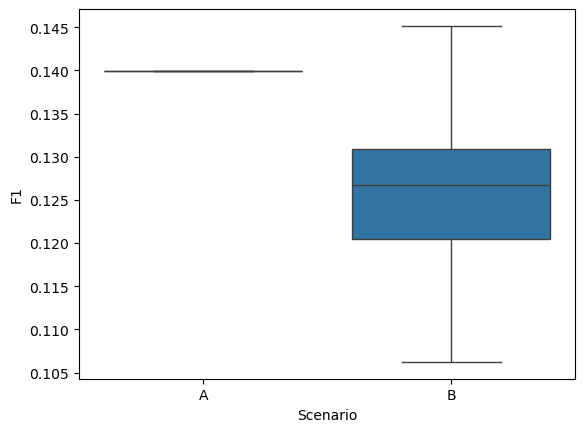

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# create plot
plot = sns.boxplot(data=results, x="Scenario", y="F1")
fig = plot.get_figure()
fig.savefig("testing_plot_{}.png".format(dataset)) 

plt.show()

In [2]:
## General parameters 

dataset = "hdfs" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

tests_scenario_C(0.3, 5, 0.3, 0.3, 0.3)
tests_scenario_C(0.3, 5, 0.3, 0.3, 0.3)

Testing scenario C using joint matrix and BerTopic topic modeling, with drain st 0.3, drain depth 5, alpha 0.3, beta 0.3, gamma 0.3, cluster number 13
The precision is 0.06899999999999865, the recall is 0.3258333333333343, the f1 score is 0.1134798515794063
F1 score: 0.1134798515794063
Testing scenario C using joint matrix and BerTopic topic modeling, with drain st 0.3, drain depth 5, alpha 0.3, beta 0.3, gamma 0.3, cluster number 13
The precision is 0.06899999999999865, the recall is 0.3258333333333343, the f1 score is 0.1134798515794063
F1 score: 0.1134798515794063


0.1134798515794063

In [ ]:
## Calculating Elbow

def clusters_elbow (unified_matrix, dataset):
    ## Clusters with cluster_kmedoids and silhouette score
    import matplotlib.pyplot as plt
    import matplotlib

    # Finding the optimal number of clusters using Elbow Method
    wcss = []
    max_clusters = 30
    for i in range(1, max_clusters):
        kmedoids = KMedoids(n_clusters=i, random_state=42)
        kmedoids.fit(unified_matrix)
        wcss.append(kmedoids.inertia_)
    plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
    plt.plot(range(1, max_clusters), wcss)
    plt.title('Elbow Method for {}'.format(dataset))
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()    

def cluster_kmedoids_silhouette(unified_matrix, cluster_num):
    ## Clusters with cluster_kmedoids and silhouette score
    from sklearn.metrics import silhouette_score

    clusterer = KMedoids(n_clusters=cluster_num, random_state=42)
    #clusterer.fit(unified_matrix)
    #print("Para {} clusters, o silhouette score é {}".format(cluster_num,silhouette_score(unified_matrix, clusterer(unified_matrix))))
    print("Para {} clusters, o silhouette score é {}".format(cluster_num, silhouette_score(unified_matrix, clusterer.fit_predict(unified_matrix))))


dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

alpha = 0.3
beta = 0.4
gamma = 0.3
vector_df = transform(os.path.basename(logName))
distance_matrix = create_distance_matrix(vector_df)
variable_matrix = create_variable_matrix()
closeness_matrix = creates_closeness_matrix(distance_matrix)
joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
clusters_elbow(joint_matrix, dataset)

In [ ]:
#cluster_kmedoids_silhouette(joint_matrix, 20)

for i in range (2,30):
    cluster_kmedoids_silhouette(joint_matrix, i)

In [ ]:
## General parameters 

dataset = "Proxifier" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_generated_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_generated_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

In [ ]:
def tests_hdbscan(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size):
    parameters = ("Testing generated clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, min cluster size {}, min samples {}, cluster selection epsilon {}, alpha {}, and leaf size {}".
          format(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size,min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix, 
                                alpha, beta, gamma)
    clustering = cluster_hdbscan(joint_matrix, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
    topic_summaries = bertopic_new_clustering()
    final = calculates_metrics()
    return (final)

def tests_kmedoids(drain_st, drain_depth, alpha, beta, gamma, cluster_num):
    parameters = ("Testing generated clustering and precomputed matrix with drain st {}, drain depth {}, alpha {}, beta {}, gamma {}, cluster_num {}".
          format(drain_st, drain_depth, alpha, beta, gamma, cluster_num))
    print(parameters)
    vector_df = transform(os.path.basename(logName))
    distance_matrix = create_distance_matrix(vector_df)
    variable_matrix = create_variable_matrix()
    closeness_matrix = creates_closeness_matrix(distance_matrix)
    joint_matrix = joins_matrices(distance_matrix, variable_matrix, closeness_matrix,alpha, beta, gamma)
    clustering = cluster_kmedoids(joint_matrix, cluster_num)
    topic_summaries = bertopic_new_clustering()
    final = calculates_metrics()
    return (final)

## General parameters 

dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.3
beta = 0.4
gamma = 0.3
cluster_num = 2

#tests_hdbscan(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_kmedoids(drain_st, drain_depth, alpha, beta, gamma, 8)
tests_kmedoids(drain_st, drain_depth, alpha, beta, gamma, 20)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth,  0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")
# tests_hdbscan(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_kmedoids(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# print("***")


In [ ]:
tests_predefined_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

print("*****")

tests_generated_rawdata(drain_st, drain_depth, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

In [ ]:
## General parameters 

dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
# tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.9, leaf_size)
# tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.8, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, leaf_size)

In [ ]:
## General parameters 

dataset = "spark" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.2
beta = 0.1
gamma = 0.7
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0
alpha_clustering = 1.0
leaf_size = 40

tests_predefined_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_predefined_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

In [ ]:
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, 2, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, 10, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, 20, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_samples, 2, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_samples, 10, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_samples, 20, cluster_selection_epsilon, alpha_clustering, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, 0.5, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, 0.25, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, 1, alpha_clustering, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.1, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, leaf_size)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, leaf_size)

tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.1, 2)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, 10)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, 20)

tests_generated_precomputed(0.2, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(0.7, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(0.1, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)


In [ ]:
## General parameters 

dataset = "bgl" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75
alpha_clustering = 0.25
leaf_size = 5

print ("teste com generated, raw data")
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, 20)
tests_generated_rawdata(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, 40)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.5, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.1, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.75, 40)

In [ ]:
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 20)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 40)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 40)
tests_generated_precomputed(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, 0.25, 40)


In [ ]:
tests_generated_precomputed(drain_st, 2, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, 7, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
tests_generated_precomputed(drain_st, 10, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)

In [ ]:
## General parameters 

dataset = "hdfs" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75
alpha_clustering = 1.0
leaf_size = 10

previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon, alpha_clustering, leaf_size)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5, alpha_clustering, leaf_size)

new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon, alpha_clustering, leaf_size)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5, alpha_clustering, leaf_size)

In [ ]:
## General parameters 

dataset = "hdfs" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75

previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.3, 0.4, 0.3, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

In [ ]:
## General parameters 

dataset = "Zookeeper" # The name of the dataset being tested

input_dir = os.path.join(os.getcwd(), "ground_truths") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
logName = dataset + '_lines.txt' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution
indir = os.path.join(input_dir, os.path.dirname(logName))
log_file = os.path.basename(logName)

## Pipeline of methods

drain_st = 0.5
drain_depth = 5
alpha = 0.7
beta = 0.2
gamma = 0.1
min_cluster_size = 5
min_samples = 5
cluster_selection_epsilon = 0.75

previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.3, 0.4, 0.3, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
previous_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.3, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(0.1, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 3, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, 5, alpha, beta, gamma, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 1, 0, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0, 1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.2, 0.1, 0.7, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.9, 0.1, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.5, 0.5, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, 0.1, 0.9, 0, min_cluster_size, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, 10, min_samples, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, 10, cluster_selection_epsilon)
new_clustering(drain_st, drain_depth, alpha, beta, gamma, min_cluster_size, min_samples, 0.5)

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

lista_f = []

with open('ground_truths/bgl_lines.txt', 'r') as fd:
    for row in fd:
        lista_f.append(row)

vectorizer_model = CountVectorizer(stop_words="english")
topic_model = BERTopic(vectorizer_model=vectorizer_model, top_n_words=5)
topics, probabilities = topic_model.fit_transform(lista_f)
topic_model.get_topic_info()

In [ ]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from hdbscan import HDBSCAN

lista_f = []

with open('ground_truths/bgl_lines.txt', 'r') as fd:
    for row in fd:
        lista_f.append(row)

vectorizer_model = CountVectorizer(stop_words="english")
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(vectorizer_model=vectorizer_model, top_n_words=5)
topics, probabilities = topic_model.fit_transform(lista_f)
topic_model.get_topic_info()